In [1]:
!pip install jams
!pip install rdflib requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64901 sha256=f2240d11bb6607ae1a542bb70225c12c932cfdd5fedc9eba65f214facc0f74f5
  Stored in directory: /root/.cache/pip/wheels/28/9a/f7/fb386b6bc5a75a3ef198a50e98b221e94a381472332b65cf24
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100699 sha256=ea797f7de4cfaf3377bdacf1789256866f6664e616f79b7384255f663d727a22
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built jams mir_eval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00


In [3]:
import json
import requests
from bs4 import BeautifulSoup

# Function to get the list of .jams file URLs from a GitHub page
def get_jams_file_urls(github_page_url):
    response = requests.get(github_page_url)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all links to .jams files
    file_urls = []
    for link in soup.find_all('a', href=True):
        if link['href'].endswith('.jams'):
            # Generate the correct "raw" URL for each file
            file_url = "https://raw.githubusercontent.com" + link['href'].replace('/blob', '')
            file_urls.append(file_url)

    return file_urls

# Function to download a .jams file from a URL
def download_jams_file(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

# Function to extract the final two chords for each section, including the key
def extract_final_chords_per_section(jams_data):
    chords_data = []
    sections_data = []
    key_data = []

    # Extract annotations for chords, sections, and key modes
    for annotation in jams_data['annotations']:
        if annotation['namespace'] == 'chord':
            for chord_event in annotation['data']:
                chords_data.append({
                    'chord': chord_event['value'],
                    'time': chord_event['time'],
                    'duration': chord_event.get('duration', 0)
                })
        elif annotation['namespace'] == 'segment_open':
            for section_event in annotation['data']:
                sections_data.append({
                    'section': section_event['value'],
                    'time': section_event['time'],
                    'duration': section_event.get('duration', 0)
                })
        elif annotation['namespace'] == 'key_mode':
            for key_event in annotation['data']:
                key_data.append({
                    'key': key_event['value'],
                    'time': key_event['time'],
                    'duration': key_event.get('duration', 0)
                })

    # Extract the final two chords of each section and their associated key
    final_chords_per_section = []
    for section in sections_data:
        section_end = section['time'] + section['duration']  # Calculate section end time

        # Filter chords that end before the section ends (considering duration)
        section_chords = [chord for chord in chords_data if chord['time'] + chord['duration'] <= section_end and chord['time'] > section_end - 3]

        # Find the key that overlaps with the section
        section_key = next((key['key'] for key in key_data if key['time'] <= section['time'] <= key['time'] + key['duration']), 'Unknown')

        # Skip the song if the key is 'Unknown'
        if section_key == 'Unknown':
            #print(f"Skipping section '{section['section']}' due to unknown key.")
            continue

        # Get the last two chords (if there are at least two)
        if len(section_chords) >= 2:
            final_two_chords = section_chords[-2:]  # Last two chords
            final_chords_per_section.append({
                'section': section['section'],
                'start_time': section['time'],
                'end_time': section_end,
                'key': section_key,  # Add the key
                'final_chords': [(chord['chord'], chord['time']) for chord in final_two_chords]
            })

    return final_chords_per_section

# Main function to analyze all .jams files on the GitHub page
def analyze_all_jams_files(github_page_url):
    # Get the list of .jams file URLs
    jams_file_urls = get_jams_file_urls(github_page_url)

    all_final_chords = []

    for file_url in jams_file_urls:
        jams_data = download_jams_file(file_url)
        final_chords_per_section = extract_final_chords_per_section(jams_data)
        all_final_chords.extend(final_chords_per_section)

    return all_final_chords

# Example GitHub page URL
github_page_url = "https://github.com/smashub/choco/tree/main/partitions/isophonics/choco/jams"
final_chords = analyze_all_jams_files(github_page_url)



In [4]:
final_chords

[{'section': 'refrain',
  'start_time': 28.891,
  'end_time': 47.543,
  'key': 'F',
  'final_chords': [('E', 45.182), ('E:min7', 46.363)]},
 {'section': 'refrain',
  'start_time': 75.628,
  'end_time': 94.18,
  'key': 'F',
  'final_chords': [('F/2', 91.889), ('G:7', 93.118)]},
 {'section': 'bridge',
  'start_time': 195.275,
  'end_time': 213.681,
  'key': 'F',
  'final_chords': [('F/2', 211.439), ('G:7', 212.582)]},
 {'section': 'refrain',
  'start_time': 28.891,
  'end_time': 47.543,
  'key': 'F',
  'final_chords': [('E', 45.182), ('E:min7', 46.363)]},
 {'section': 'refrain',
  'start_time': 75.628,
  'end_time': 94.18,
  'key': 'F',
  'final_chords': [('F/2', 91.889), ('G:7', 93.118)]},
 {'section': 'bridge',
  'start_time': 195.275,
  'end_time': 213.681,
  'key': 'F',
  'final_chords': [('F/2', 211.439), ('G:7', 212.582)]},
 {'section': 'silence',
  'start_time': 0.0,
  'end_time': 1.091,
  'key': 'F',
  'final_chords': [('N', 0.0), ('E:(1)', 0.497838)]},
 {'section': 'verse',
  's

In [5]:
len(final_chords)

354

In [6]:
from google.colab import files

uploaded = files.upload()

Saving Cadence1309.rdf to Cadence1309.rdf


In [7]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD

# Carico il grafo RDF dall'a tua 'ontologia
g = Graph()
g.parse("Cadence1309.rdf", format="xml")

# Definisco il namespace dell'ontologia
ns = Namespace("http://www.example.com/cadences.owl#")

In [8]:
# Mappa delle scale diatoniche maggiori e minori
diatonic_major_scale = {
    'C': ['C', 'D', 'E', 'F', 'G', 'A', 'B'],
    'G': ['G', 'A', 'B', 'C', 'D', 'E', 'F#'],
    'D': ['D', 'E', 'F#', 'G', 'A', 'B', 'C#'],
    'A': ['A', 'B', 'C#', 'D', 'E', 'F#', 'G#'],
    'E': ['E', 'F#', 'G#', 'A', 'B', 'C#', 'D#'],
    'B': ['B', 'C#', 'D#', 'E', 'F#', 'G#', 'A#'],
    'F#': ['F#', 'G#', 'A#', 'B', 'C#', 'D#', 'E#'],
    'C#': ['C#', 'D#', 'E#', 'F#', 'G#', 'A#', 'B#'],
    'F': ['F', 'G', 'A', 'Bb', 'C', 'D', 'E'],
    'Bb': ['Bb', 'C', 'D', 'Eb', 'F', 'G', 'A'],
    'Eb': ['Eb', 'F', 'G', 'Ab', 'Bb', 'C', 'D'],
    'Ab': ['Ab', 'Bb', 'C', 'Db', 'Eb', 'F', 'G'],
    'Db': ['Db', 'Eb', 'F', 'Gb', 'Ab', 'Bb', 'C'],
    'Gb': ['Gb', 'Ab', 'Bb', 'Cb', 'Db', 'Eb', 'F'],
    'Cb': ['Cb', 'Db', 'Eb', 'Fb', 'Gb', 'Ab', 'Bb'],
    'G#': ['G#', 'A#', 'B#', 'C#', 'D#', 'E#', 'Fx'],
    'A#': ['A#', 'B#', 'Cx', 'D#', 'E#', 'Fx', 'Gx'],
    'D#': ['D#', 'E#', 'Fx', 'G#', 'A#', 'B#', 'Cx'],
    'E#': ['E#', 'Fx', 'Gx', 'A#', 'B#', 'Cx', 'Dx'],
    'Fb': ['Fb', 'Gb', 'Ab', 'Bbb', 'Cb', 'Db', 'Eb'],
    'B#': ['B#', 'Cx', 'Dx', 'E#', 'Fx', 'Gx', 'Ax']
}

diatonic_minor_scale = {
    'A': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    'E': ['E', 'F#', 'G', 'A', 'B', 'C', 'D'],
    'B': ['B', 'C#', 'D', 'E', 'F#', 'G', 'A'],
    'F#': ['F#', 'G#', 'A', 'B', 'C#', 'D', 'E'],
    'C#': ['C#', 'D#', 'E', 'F#', 'G#', 'A', 'B'],
    'G#': ['G#', 'A#', 'B', 'C#', 'D#', 'E', 'F#'],
    'D#': ['D#', 'E#', 'F#', 'G#', 'A#', 'B', 'C#'],
    'A#': ['A#', 'B#', 'C#', 'D#', 'E#', 'F#', 'G#'],
    'D': ['D', 'E', 'F', 'G', 'A', 'Bb', 'C'],
    'G': ['G', 'A', 'Bb', 'C', 'D', 'Eb', 'F'],
    'C': ['C', 'D', 'Eb', 'F', 'G', 'Ab', 'Bb'],
    'F': ['F', 'G', 'Ab', 'Bb', 'C', 'Db', 'Eb'],
    'Bb': ['Bb', 'C', 'Db', 'Eb', 'F', 'Gb', 'Ab'],
    'Eb': ['Eb', 'F', 'Gb', 'Ab', 'Bb', 'Cb', 'Db'],
    'Ab': ['Ab', 'Bb', 'Cb', 'Db', 'Eb', 'Fb', 'Gb'],
    'Db': ['Db', 'Eb', 'Fb', 'Gb', 'Ab', 'Bbb', 'Cb'],
    'Gb': ['Gb', 'Ab', 'Bb', 'Cb', 'Db', 'Ebb', 'Fb'],
    'A#': ['A#', 'B#', 'C#', 'D#', 'E#', 'F#', 'G#'],
    'D#': ['D#', 'E#', 'F#', 'G#', 'A#', 'B', 'C#'],
    'E#': ['E#', 'F##', 'G#', 'A#', 'B#', 'C##', 'D#'],
    'Fb': ['Fb', 'Gb', 'Abb', 'Bbb', 'Cb', 'Db', 'Ebb'],
    'B#': ['B#', 'C##', 'D#', 'E#', 'F##', 'G#', 'A#']
}


In [9]:
# Function to determine the harmonic degree of a chord relative to a key
def determina_grado_accordo(chord, key):
    # Extract the root note of the chord, ignoring inversions or alterations
    root_note = chord.split(':')[0].split('/')[0]

    # Determine if the key is major or minor
    is_minor = 'min' in key
    key_root = key.split(':')[0]  # Root note of the key

    # Select the appropriate scale (major or minor)
    if is_minor:
        scale = diatonic_minor_scale.get(key_root)
    else:
        scale = diatonic_major_scale.get(key_root)

    # Handle missing scales
    if not scale:
        print(f"Errore: tonalità {key_root} non trovata in diatonic_major_scale o diatonic_minor_scale")
        return None

    # If the note is in the scale, return its degree
    if root_note in scale:
        degree = scale.index(root_note) + 1  # Degrees are 1-based
        degree_mapping = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']
        return degree_mapping[degree - 1]
    else:
        return None

# Funzione per determinare il tipo di cadenza
def determina_tipo_cadenza(preceding_chord, following_chord, key):
    preceding_degree = determina_grado_accordo(preceding_chord, key)
    following_degree = determina_grado_accordo(following_chord, key)
    #print(f"{preceding_degree} -> {following_degree}")

      # Cadenza perfetta (V -> I in posizione fondamentale)
    if preceding_degree == 'V' and following_degree == 'I' and '/' not in preceding_chord and '/' not in following_chord:
        return ns.Perfect, 'Perfect'

    # Cadenza imperfetta (V -> I con inversione)
    elif preceding_degree == 'V' and following_degree == 'I' and ('/' in preceding_chord or '/' in following_chord):
        return ns.Imperfect, 'Imperfect'

    # Cadenza d'inganno (V -> VI generica)
    elif preceding_degree == 'V' and  following_degree=='VI':
        return ns.Deceptive, 'Deceptive'

    # Cadenza plagale (IV -> I)
    elif preceding_degree == 'IV' and following_degree == 'I':
        return ns.Plagal, 'Plagal'

    # Cadenza avoided (V -> not(I, VI))
    elif preceding_degree == 'V' and  following_degree not in ['I', 'VI']:
        return ns.Avoided, 'Avoided'

    # Cadenza sospesa (['I', 'II', 'IV', 'VI'] -> V)
    elif preceding_degree in ['I', 'II', 'IV', 'VI'] and following_degree == 'V':
        return ns.Half, 'Half'

    else:
      #print(f"{preceding_degree} -> {following_degree}")
      # Default, nel caso non sia cadenza principale
      return ns.Cadence, 'Cadence'

In [10]:
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, XSD


# Funzione per popolare l'ontologia
def popola_ontologia(dati, ontologia_path, output_path):

    # Contatore globale per le cadenze
    cadence_counter = 1

    for dato in dati:
        section_name = dato['section']
        key_name = dato['key']
        final_chords = dato['final_chords']

        # Itera su accordi per det. la cadenza
        for i in range(len(final_chords) - 1):
            preceding_chord_name = final_chords[i][0]
            following_chord_name = final_chords[i + 1][0]

            # URI  sezione
            section_uri = URIRef(ns + f"section_{section_name}")
            g.add((section_uri, RDF.type, ns.Section))
            g.add((section_uri, ns.hasName, Literal(section_name, datatype=XSD.string)))

            # URI tonalità (Key)
            key_uri = URIRef(ns + f"key_{key_name.replace(':', '_')}")
            g.add((key_uri, RDF.type, ns.Key))
            g.add((key_uri, ns.hasName, Literal(key_name, datatype=XSD.string)))

            # Determina il tipo di cadenza
            cadenza_type_uri, cadenza_type_name = determina_tipo_cadenza(preceding_chord_name, following_chord_name, key_name)

            # Usa un contatore per creare un URI univoco ma ordinato per cadenza
            cadenza_uri = URIRef(ns + f"cadence_{cadenza_type_name}_{section_name}_{cadence_counter}")
            #g.add((cadenza_uri, RDF.type, ns.Cadence))
            g.add((cadenza_uri, RDF.type, cadenza_type_uri))
            g.add((cadenza_uri, ns.belongsToSection, section_uri))

            # Incrementa il contatore delle cadenze
            cadence_counter += 1

            # URI accordi
            preceding_chord_uri = URIRef(ns + f"chord_{preceding_chord_name.replace(':', '_').replace('/', '_')}")
            following_chord_uri = URIRef(ns + f"chord_{following_chord_name.replace(':', '_').replace('/', '_')}")
            g.add((preceding_chord_uri, RDF.type, ns.Chord))
            g.add((preceding_chord_uri, ns.hasName, Literal(preceding_chord_name, datatype=XSD.string)))
            g.add((following_chord_uri, RDF.type, ns.Chord))
            g.add((following_chord_uri, ns.hasName, Literal(following_chord_name, datatype=XSD.string)))

            # Aggiungi gradi e accordi alla cadenza
            preceding_degree = determina_grado_accordo(preceding_chord_name, key_name)
            following_degree = determina_grado_accordo(following_chord_name, key_name)

            if preceding_degree:
                degree_uri_preceding = URIRef(ns + f"degree_{preceding_degree}_{preceding_chord_name}_{key_name}")
                g.add((cadenza_uri, ns.hasPrecedingDegree, degree_uri_preceding))
                g.add((degree_uri_preceding, ns.hasChord, preceding_chord_uri))
                g.add((degree_uri_preceding, ns.hasKey, key_uri))

            if following_degree:
                degree_uri_following = URIRef(ns + f"degree_{following_degree}_{following_chord_name}_{key_name}")
                g.add((cadenza_uri, ns.hasFollowingDegree, degree_uri_following))
                g.add((degree_uri_following, ns.hasChord, following_chord_uri))
                g.add((degree_uri_following, ns.hasKey, key_uri))

    # Salva l'ontologia aggiornata in un file
    g.serialize(destination=output_path, format="xml")


# popolo ontologia
ontologia_path = 'Cadence1209.rdf'
output_path = 'ontologia_popolata.owl'

popola_ontologia(final_chords, ontologia_path, output_path)


In [11]:
# Stampa tutti i dati del grafo
print("Triples presenti nel grafo RDF:")
for subj, pred, obj in g:
    print(f"Soggetto: {subj}")
    print(f"Predicato: {pred}")
    print(f"Oggetto: {obj}")
    print("-----")

Output streaming troncato alle ultime 5000 righe.
Soggetto: http://www.example.com/cadences.owl#cadence_Perfect_verse_259
Predicato: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
Oggetto: http://www.example.com/cadences.owl#Perfect
-----
Soggetto: http://www.example.com/cadences.owl#key_F_minor
Predicato: http://www.example.com/cadences.owl#hasName
Oggetto: F:minor
-----
Soggetto: http://www.example.com/cadences.owl#cadence_Cadence_intro_306
Predicato: http://www.example.com/cadences.owl#belongsToSection
Oggetto: http://www.example.com/cadences.owl#section_intro
-----
Soggetto: http://www.example.com/cadences.owl#degree_V_D_G:mixolydian
Predicato: http://www.example.com/cadences.owl#hasChord
Oggetto: http://www.example.com/cadences.owl#chord_D
-----
Soggetto: http://www.example.com/cadences.owl#degree_IV_G/#4_D
Predicato: http://www.example.com/cadences.owl#hasChord
Oggetto: http://www.example.com/cadences.owl#chord_G_#4
-----
Soggetto: http://www.example.com/cadences.owl#cadence_Per

In [12]:
from rdflib import Graph, Namespace


def load_ontology(ontology_path):
    g = Graph()
    g.parse(ontology_path)
    return g

# Funzione per rimuovere tutti gli individuals dall'ontologia
def remove_individuals(ontology_path, output_path):
    g = load_ontology(ontology_path)

    ns = Namespace("http://www.example.com/cadences.owl#")

    # Query per selezionare tutti gli individuals nell'ontologia
    query = """
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    SELECT ?individual
    WHERE {
      ?individual a owl:NamedIndividual .
    }
    """

    # Esegui la query per ottenere tutti gli individuals
    individuals = g.query(query)

    # Rimuovi tutti gli individuals
    for row in individuals:
        individual_uri = row.individual
        # Rimuovi tutte le triple associate a ciascun individual
        g.remove((individual_uri, None, None))

    # Salva l'ontologia modificata in un nuovo file
    g.serialize(destination=output_path, format='xml')

    print(f"Rimossi gli individuals e salvato il nuovo file RDF in {output_path}")


ontology_path = 'ontologia_popolata.owl'  # Il file RDF con gli individuals
output_path = 'ontologia_senza_individuals.owl'  # Il file RDF senza gli individuals
remove_individuals(ontology_path, output_path)


Rimossi gli individuals e salvato il nuovo file RDF in ontologia_senza_individuals.owl


In [13]:
def conta_cadenze_per_sezione(ontology_path):
    g = Graph()
    g.parse(ontology_path)

    query = """
    PREFIX : <http://www.example.com/cadences.owl#>
    SELECT ?section ?cadenceType (COUNT(?cadence) AS ?cadenceCount)
    WHERE {
      ?cadence a ?cadenceType ;
               :belongsToSection ?section .
      FILTER (?cadenceType IN (:Perfect, :Imperfect, :Deceptive, :Plagal, :Half, :Cadence, :Avoided))
    }
    GROUP BY ?section ?cadenceType
    ORDER BY ?section
    """

    results = g.query(query)
    cadence_data = {}
    for row in results:
        section = str(row.section).split("#")[-1]
        cadence_type = str(row.cadenceType).split("#")[-1]
        cadence_count = int(row.cadenceCount.value)
        print(f"Sezione: {section:<40} Cadenza: {cadence_type:<15} Conteggio: {cadence_count:<10}")
        if section not in cadence_data:
            cadence_data[section] = {}

        cadence_data[section][cadence_type] = cadence_count
    return cadence_data


# Esegui il conteggio
cadence_data = conta_cadenze_per_sezione('ontologia_senza_individuals.owl')

Sezione: section_break                            Cadenza: Cadence         Conteggio: 6         
Sezione: section_bridge                           Cadenza: Cadence         Conteggio: 14        
Sezione: section_bridge                           Cadenza: Perfect         Conteggio: 2         
Sezione: section_bridge                           Cadenza: Half            Conteggio: 10        
Sezione: section_bridge                           Cadenza: Avoided         Conteggio: 8         
Sezione: section_bridge_(instrumental)            Cadenza: Half            Conteggio: 2         
Sezione: section_chorus                           Cadenza: Cadence         Conteggio: 2         
Sezione: section_instrumental                     Cadenza: Cadence         Conteggio: 4         
Sezione: section_interlude                        Cadenza: Half            Conteggio: 2         
Sezione: section_interlude                        Cadenza: Plagal          Conteggio: 2         
Sezione: section_interlude    

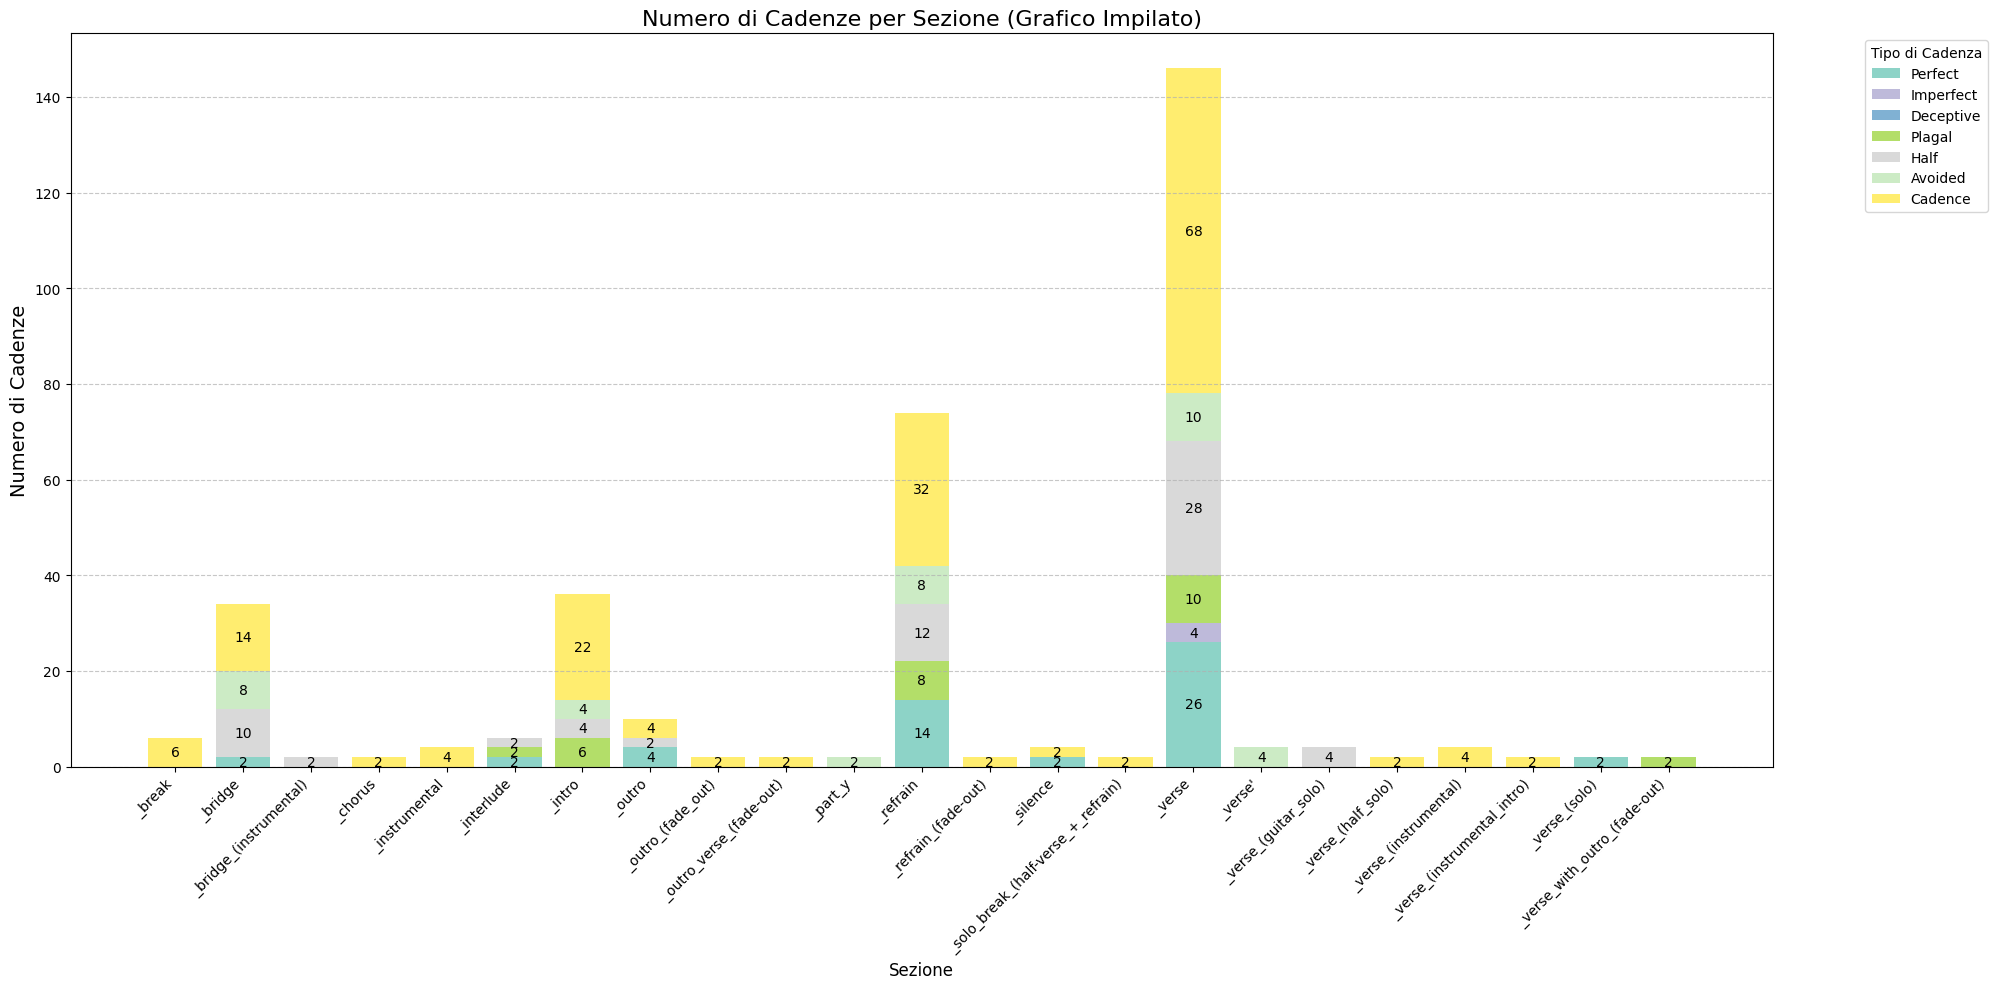

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Remove the word "section" from each section name
sections = [section.replace('section', '') for section in cadence_data.keys()]

cadence_types = ['Perfect', 'Imperfect', 'Deceptive', 'Plagal', 'Half', 'Avoided', 'Cadence']

counts_per_cadence = {cadence: [] for cadence in cadence_types}


for section in cadence_data:
    for cadence_type in cadence_types:
        counts_per_cadence[cadence_type].append(cadence_data[section].get(cadence_type, 0))

# Trasforma i dati in array per facilitarne l'uso nel grafico a barre impilate
data = np.array([counts_per_cadence[cadence] for cadence in cadence_types])

# grafico a barre impilate
fig, ax = plt.subplots(figsize=(20, 10))


bottom = np.zeros(len(sections))
colors = plt.cm.Set3(np.linspace(0, 1, len(cadence_types)))  # cambio colore

for i, cadence_type in enumerate(cadence_types):
    bars = ax.bar(sections, data[i], bottom=bottom, label=cadence_type, color=colors[i])

    # Aggiungi il numero delle cadenze su ogni barra impilata
    for bar, count in zip(bars, data[i]):
        if count > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                    f'{int(count)}', ha='center', va='center', fontsize=10, color='black')

    bottom += data[i]

#etichette e titolo
ax.set_xlabel('Sezione', fontsize=12)
ax.set_ylabel('Numero di Cadenze', fontsize=14)
ax.set_title('Numero di Cadenze per Sezione (Grafico Impilato)', fontsize=16)
# Rotate section labels by 45 degrees for better readability
plt.xticks(rotation=45, ha='right')

#egenda
ax.legend(title="Tipo di Cadenza", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()


plt.show()





In [18]:
from rdflib import Graph

def load_ontology(ontology_path):
    g = Graph()
    g.parse(ontology_path)
    return g

# Funzione per eseguire una query SPARQL che estrae le cadenze perfette, i gradi e gli accordi
def query_dettagli_cadenze_perfette(ontology_path):
    g = load_ontology(ontology_path)

    #query SPARQL per estrarre tutte le cadenze perfette con i gradi e gli accordi
    query = """
    PREFIX : <http://www.example.com/cadences.owl#>
    SELECT ?cadence ?section ?precedingDegree ?precedingChord ?followingDegree ?followingChord
    WHERE {
      ?cadence a :Perfect ;
               :belongsToSection ?section ;
               :hasPrecedingDegree ?precedingDegree ;
               :hasFollowingDegree ?followingDegree .
      ?precedingDegree :hasChord ?precedingChord .
      ?followingDegree :hasChord ?followingChord .
    }
    ORDER BY ?section
    """

    # Esegui
    results = g.query(query)

    # Stampa i risultati
    for row in results:
        cadence = str(row.cadence).split("#")[-1]
        section = str(row.section).split("#")[-1]
        preceding_degree = str(row.precedingDegree).split("#")[-1]
        preceding_chord = str(row.precedingChord).split("#")[-1]
        following_degree = str(row.followingDegree).split("#")[-1]
        following_chord = str(row.followingChord).split("#")[-1]

        print(f"Cadenza: {cadence}, Sezione: {section}")
        print(f"  Grado Precedente: {preceding_degree}, Accordo Precedente: {preceding_chord}")
        print(f"  Grado Seguente: {following_degree}, Accordo Seguente: {following_chord}")
        print("----------------------------------------------------------")

# Esempio di utilizzo
ontologia_path = 'ontologia_popolata.owl'
query_dettagli_cadenze_perfette(ontologia_path)

Cadenza: PerfectCadenceExample1, Sezione: SectionVerse
  Grado Precedente: Degree5, Accordo Precedente: G7Chord
  Grado Seguente: Degree1, Accordo Seguente: CMajorChord
----------------------------------------------------------
Cadenza: cadence_Perfect_bridge_348, Sezione: section_bridge
  Grado Precedente: degree_V_E:7_A, Accordo Precedente: chord_E_7
  Grado Seguente: degree_I_A_A, Accordo Seguente: chord_A
----------------------------------------------------------
Cadenza: cadence_Perfect_bridge_347, Sezione: section_bridge
  Grado Precedente: degree_V_E:7_A, Accordo Precedente: chord_E_7
  Grado Seguente: degree_I_A_A, Accordo Seguente: chord_A
----------------------------------------------------------
Cadenza: cadence_Perfect_interlude_14, Sezione: section_interlude
  Grado Precedente: degree_V_D:sus4(b7)_G, Accordo Precedente: chord_D_sus4(b7)
  Grado Seguente: degree_I_G_G, Accordo Seguente: chord_G
----------------------------------------------------------
Cadenza: cadence_Perf

In [19]:
from rdflib import Graph

def load_ontology(ontology_path):
    g = Graph()
    g.parse(ontology_path)
    return g

#query SPARQL che conta gli accordi precedenti e seguenti nelle cadenze perfette
def query_accordi_precedenti_e_seguenti_cadenze_perfette(ontology_path):
    g = load_ontology(ontology_path)

    # Query SPARQL per contare gli accordi precedenti e seguenti
    query = """
    PREFIX : <http://www.example.com/cadences.owl#>
    SELECT ?precedingChord ?followingChord (COUNT(?cadence) AS ?chordCount)
    WHERE {
      ?cadence a :Perfect ;
               :hasPrecedingDegree ?precedingDegree ;
               :hasFollowingDegree ?followingDegree .
      ?precedingDegree :hasChord ?precedingChord .
      ?followingDegree :hasChord ?followingChord .
    }
    GROUP BY ?precedingChord ?followingChord
    ORDER BY DESC(?chordCount)
    """

    results = g.query(query)

    for row in results:
        hash_index_preceding = str(row.precedingChord).index('#')
        hash_index_following = str(row.followingChord).index('#')

        preceding_chord = str(row.precedingChord)[hash_index_preceding+1:]
        following_chord = str(row.followingChord)[hash_index_following+1:]
        chord_count = int(row.chordCount.value)
        print(f"Accordo Precedente: {preceding_chord:<20} Accordo Seguente: {following_chord:<20} Conteggio: {chord_count:<10}")


ontologia_path = 'ontologia_senza_individuals.owl'
query_accordi_precedenti_e_seguenti_cadenze_perfette(ontologia_path)



Accordo Precedente: chord_D              Accordo Seguente: chord_G              Conteggio: 10        
Accordo Precedente: chord_E              Accordo Seguente: chord_A              Conteggio: 10        
Accordo Precedente: chord_Ab             Accordo Seguente: chord_Db             Conteggio: 8         
Accordo Precedente: chord_C#_7           Accordo Seguente: chord_F#_min         Conteggio: 6         
Accordo Precedente: chord_D_sus4(b7)     Accordo Seguente: chord_G              Conteggio: 6         
Accordo Precedente: chord_C#             Accordo Seguente: chord_F#_min         Conteggio: 4         
Accordo Precedente: chord_E_7            Accordo Seguente: chord_A              Conteggio: 2         
Accordo Precedente: chord_B_7            Accordo Seguente: chord_E              Conteggio: 2         
Accordo Precedente: chord_A              Accordo Seguente: chord_D              Conteggio: 2         
Accordo Precedente: chord_G              Accordo Seguente: chord_C_min          Co

In [20]:
from rdflib import Graph

def load_ontology(ontology_path):
    g = Graph()
    g.parse(ontology_path)
    return g

# Funzione per query SPARQL che conta gli accordi precedenti e seguenti per ogni tonalità
def query_accordi_precedenti_e_seguenti_per_tonalita(ontology_path):
    g = load_ontology(ontology_path)

    # Query SPARQL per contare gli accordi precedenti e seguenti per ogni tonalità
    query = """
    PREFIX : <http://www.example.com/cadences.owl#>
    SELECT ?key ?precedingChord ?followingChord (COUNT(?cadence) AS ?cadenceCount)
    WHERE {
      ?cadence a :Perfect ;
               :hasPrecedingDegree ?precedingDegree ;
               :hasFollowingDegree ?followingDegree .
      ?precedingDegree :hasChord ?precedingChord ;
                       :hasKey ?key .
      ?followingDegree :hasChord ?followingChord ;
                       :hasKey ?key .
    }
    GROUP BY ?key ?precedingChord ?followingChord
    ORDER BY ?key DESC(?cadenceCount)
    """

    # Esegui query SPARQL
    results = g.query(query)

    #lista per i dati
    data = {
        'Tonalità': [],
        'Accordo Precedente': [],
        'Accordo Seguente': [],
        'Conteggio': []
    }

    print(f"Frequenza accordi per cadenza Perfetta")
    for row in results:
        hash_index_preceding = str(row.precedingChord).index('#')
        hash_index_following = str(row.followingChord).index('#')
        hash_index_key = str(row.key).index('#')

        preceding_chord = str(row.precedingChord)[hash_index_preceding+1:]  # Nome dell'accordo precedente
        following_chord = str(row.followingChord)[hash_index_following+1:]  # Nome dell'accordo seguente
        key = str(row.key)[hash_index_key+1:]  # Nome della tonalità
        cadence_count = int(row.cadenceCount.value)  # Conteggio delle cadenze

        print(f"Tonalità: {key:<10} Accordo Precedente: {preceding_chord:<20} Accordo Seguente: {following_chord:<20} Conteggio: {cadence_count:<10}")

        # dizionario dati
        data['Tonalità'].append(key)
        data['Accordo Precedente'].append(preceding_chord)
        data['Accordo Seguente'].append(following_chord)
        data['Conteggio'].append(cadence_count)

    return data

ontologia_path = 'ontologia_senza_individuals.owl'
data = query_accordi_precedenti_e_seguenti_per_tonalita(ontologia_path)



Frequenza accordi per cadenza Perfetta
Tonalità: key_A      Accordo Precedente: chord_E              Accordo Seguente: chord_A              Conteggio: 10        
Tonalità: key_A      Accordo Precedente: chord_E_7            Accordo Seguente: chord_A              Conteggio: 2         
Tonalità: key_C_minor Accordo Precedente: chord_G              Accordo Seguente: chord_C_min          Conteggio: 2         
Tonalità: key_D      Accordo Precedente: chord_A              Accordo Seguente: chord_D              Conteggio: 2         
Tonalità: key_Db     Accordo Precedente: chord_Ab             Accordo Seguente: chord_Db             Conteggio: 8         
Tonalità: key_E      Accordo Precedente: chord_B_7            Accordo Seguente: chord_E              Conteggio: 2         
Tonalità: key_F#_minor Accordo Precedente: chord_C#_7           Accordo Seguente: chord_F#_min         Conteggio: 6         
Tonalità: key_F#_minor Accordo Precedente: chord_C#             Accordo Seguente: chord_F#_min   

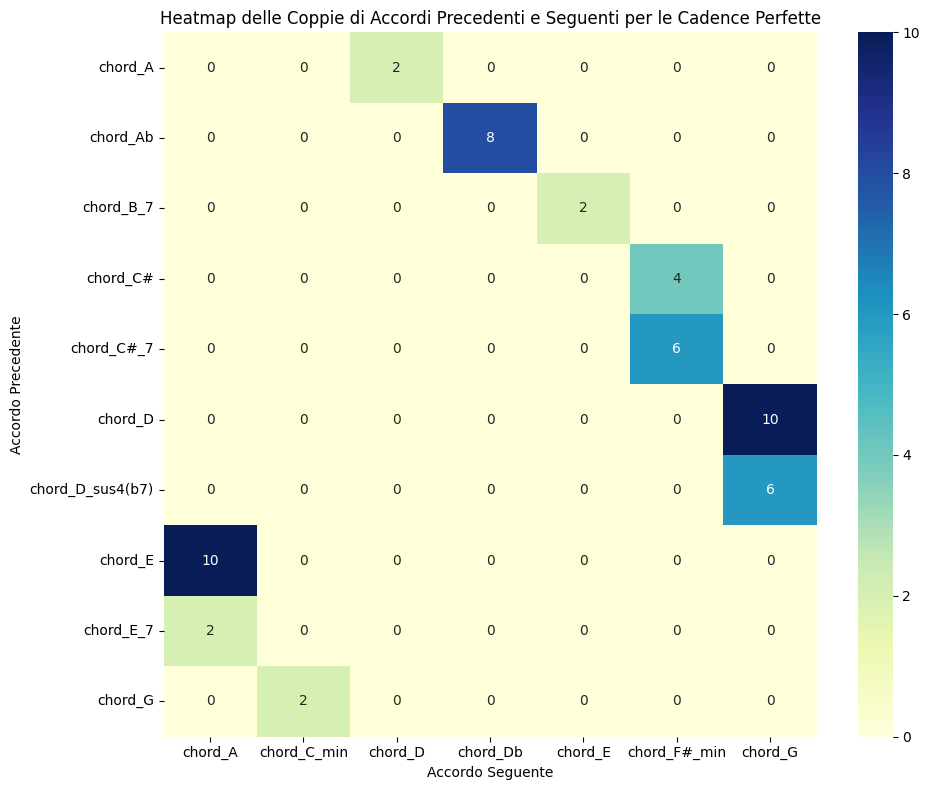

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def create_heatmap(data):
    # Crea un DataFrame per dati
    df = pd.DataFrame(data)

    pivot_table = df.pivot_table(
        values='Conteggio',  # Il valore da visualizzare
        index='Accordo Precedente',  # Riga: Accordo Precedente
        columns='Accordo Seguente',  # Colonna: Accordo Seguente
        aggfunc='sum',  # Somma i valori
        fill_value=0  # Riempie i valori mancanti con 0
    )

    # heatmap utilizzando seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", cbar=True)

    # etichette e titolo
    plt.title("Heatmap delle Coppie di Accordi Precedenti e Seguenti per le Cadence Perfette")
    plt.xlabel("Accordo Seguente")
    plt.ylabel("Accordo Precedente")


    plt.tight_layout()
    plt.show()



create_heatmap(data)


In [24]:
from rdflib import Graph

def load_ontology(ontology_path):
    g = Graph()
    g.parse(ontology_path)
    return g

# Funzione per  query SPARQL che conta le cadenze per tonalità e tipologia
def query_conta_cadenze_per_tonalita_e_tipologia(ontology_path):

    g = load_ontology(ontology_path)

    # Query SPARQL per contare le cadenze per tonalità e tipologia
    query = """
    PREFIX : <http://www.example.com/cadences.owl#>
    SELECT ?key ?cadenceType (COUNT(?cadence) AS ?cadenceCount)
    WHERE {
      ?cadence a ?cadenceType ;
               :hasFollowingDegree ?followingDegree ;
      { ?followingDegree :hasKey ?key }


      FILTER(?cadenceType IN (:Perfect, :Imperfect, :Deceptive, :Plagal, :Half, :Cadence, :Avoided))
    }
    GROUP BY ?key ?cadenceType
    ORDER BY ?key DESC(?cadenceCount)
    """

    # Esegui query.
    results = g.query(query)


    key_data = {}
    for row in results:
        hash_index = str(row.key).index('#')
        key = str(row.key)[hash_index+1:]  # Prendo il nome della tonalità
        cadence_type = str(row.cadenceType).split("#")[-1]  # Prendo il nome del tipo di cadenza
        cadence_count = int(row.cadenceCount)  # Conteggio delle cadenze per tipo
        print(f"Tonalità: {key:<10} Tipo di cadenza: {cadence_type:<15} Conteggio: {cadence_count:<10}")
        if key not in key_data:
            key_data[key] = {}

        key_data[key][cadence_type] = cadence_count

    return key_data


ontologia_path = 'ontologia_senza_individuals.owl'
key_data = query_conta_cadenze_per_tonalita_e_tipologia(ontologia_path)


Tonalità: key_A      Tipo di cadenza: Cadence         Conteggio: 42        
Tonalità: key_A      Tipo di cadenza: Half            Conteggio: 16        
Tonalità: key_A      Tipo di cadenza: Perfect         Conteggio: 12        
Tonalità: key_A      Tipo di cadenza: Plagal          Conteggio: 8         
Tonalità: key_A      Tipo di cadenza: Avoided         Conteggio: 4         
Tonalità: key_A_minor Tipo di cadenza: Avoided         Conteggio: 4         
Tonalità: key_Ab     Tipo di cadenza: Cadence         Conteggio: 6         
Tonalità: key_Ab     Tipo di cadenza: Plagal          Conteggio: 4         
Tonalità: key_Ab     Tipo di cadenza: Avoided         Conteggio: 4         
Tonalità: key_C      Tipo di cadenza: Cadence         Conteggio: 16        
Tonalità: key_C      Tipo di cadenza: Avoided         Conteggio: 6         
Tonalità: key_C      Tipo di cadenza: Half            Conteggio: 4         
Tonalità: key_C      Tipo di cadenza: Imperfect       Conteggio: 2         
Tonalità: k

In [25]:
key_data

{'key_A': {'Cadence': 42,
  'Half': 16,
  'Perfect': 12,
  'Plagal': 8,
  'Avoided': 4},
 'key_A_minor': {'Avoided': 4},
 'key_Ab': {'Cadence': 6, 'Plagal': 4, 'Avoided': 4},
 'key_C': {'Cadence': 16, 'Avoided': 6, 'Half': 4, 'Imperfect': 2},
 'key_C_minor': {'Half': 6, 'Cadence': 4, 'Perfect': 2},
 'key_D': {'Half': 10, 'Cadence': 6, 'Plagal': 4, 'Avoided': 4, 'Perfect': 2},
 'key_D_minor': {'Half': 2},
 'key_Db': {'Perfect': 8},
 'key_E': {'Cadence': 10, 'Plagal': 6, 'Half': 6, 'Perfect': 2},
 'key_F': {'Cadence': 8, 'Plagal': 6, 'Half': 2},
 'key_F#': {'Cadence': 2},
 'key_F#_minor': {'Perfect': 10, 'Half': 2, 'Avoided': 2},
 'key_F_minor': {'Cadence': 2},
 'key_G': {'Cadence': 28,
  'Perfect': 16,
  'Half': 12,
  'Imperfect': 2,
  'Avoided': 2},
 'key_G_mixolydian': {'Avoided': 8, 'Half': 4, 'Cadence': 2}}

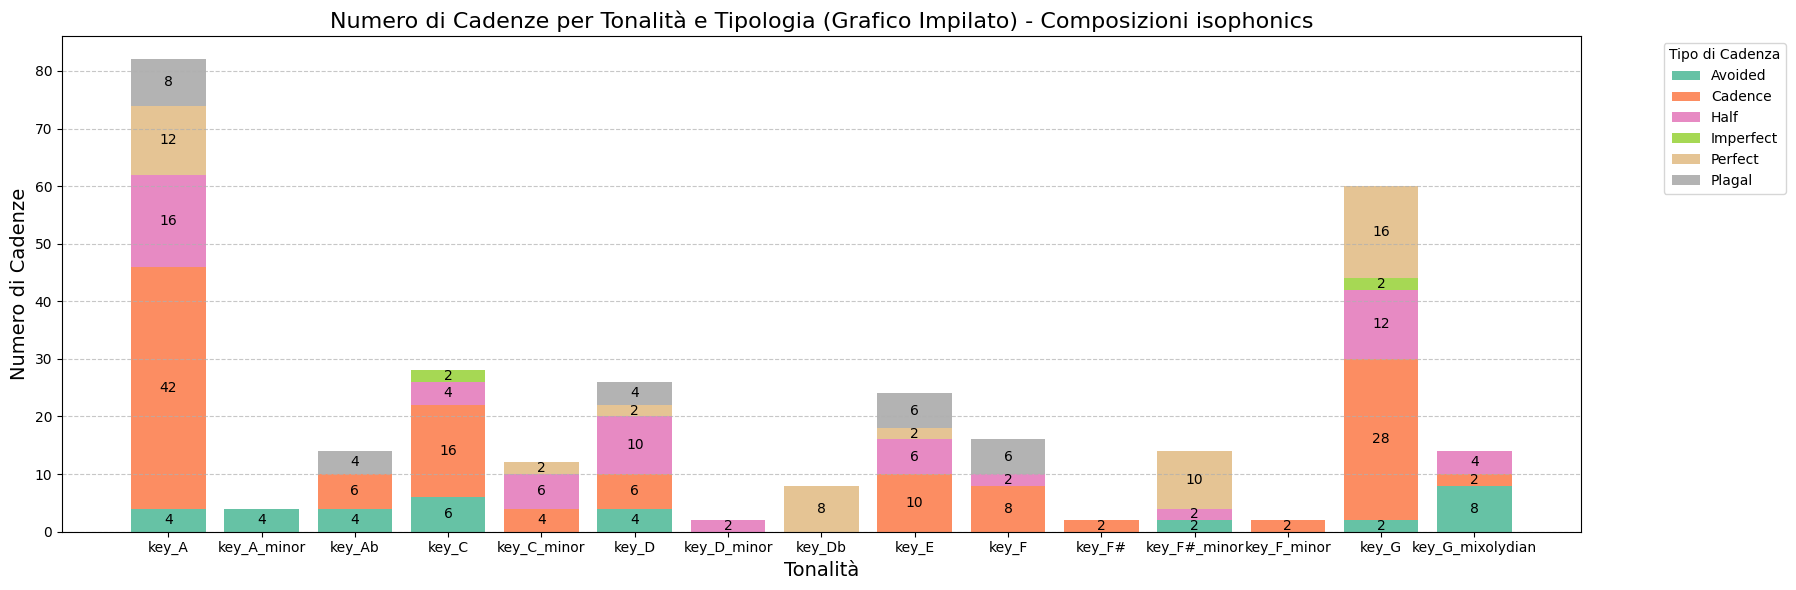

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stacked_bar_chart_with_numbers(cadence_data):
    # Estrai tutte le tonalità e tipi di cadenze unici
    keys = list(cadence_data.keys())

    all_cadence_types = set()
    for key in keys:
        all_cadence_types.update(cadence_data[key].keys())
    cadence_types = sorted(list(all_cadence_types))

    n_keys = len(keys)
    n_cadence_types = len(cadence_types)

    # struttura per contare le cadenze per tonalità e tipo di cadenza
    cadence_counts = np.zeros((n_cadence_types, n_keys))
    for i, cadence_type in enumerate(cadence_types):
        for j, key in enumerate(keys):
            cadence_counts[i, j] = cadence_data[key].get(cadence_type, 0)

    #grafico a barre impilate
    fig, ax = plt.subplots(figsize=(18, 6))

    #palette
    colors = plt.cm.Set2(np.linspace(0, 1, n_cadence_types))

    bottom = np.zeros(n_keys)

    # Aggiungo  barre impilate
    for i, cadence_type in enumerate(cadence_types):
        bars = ax.bar(keys, cadence_counts[i], label=cadence_type, bottom=bottom, color=colors[i])

        # Aggiungo  numero di cadenze dentro le barre
        for bar, count in zip(bars, cadence_counts[i]):
            if count > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                        f'{int(count)}', ha='center', va='center', fontsize=10, color='black')

        bottom += cadence_counts[i]

    # etichette e titolo
    ax.set_xlabel('Tonalità', fontsize=14)
    ax.set_ylabel('Numero di Cadenze', fontsize=14)
    ax.set_title('Numero di Cadenze per Tonalità e Tipologia (Grafico Impilato) - Composizioni isophonics', fontsize=16)

    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # legenda
    ax.legend(title="Tipo di Cadenza", bbox_to_anchor=(1.05, 1), loc='upper left')


    plt.tight_layout()


    plt.show()




plot_stacked_bar_chart_with_numbers(key_data)



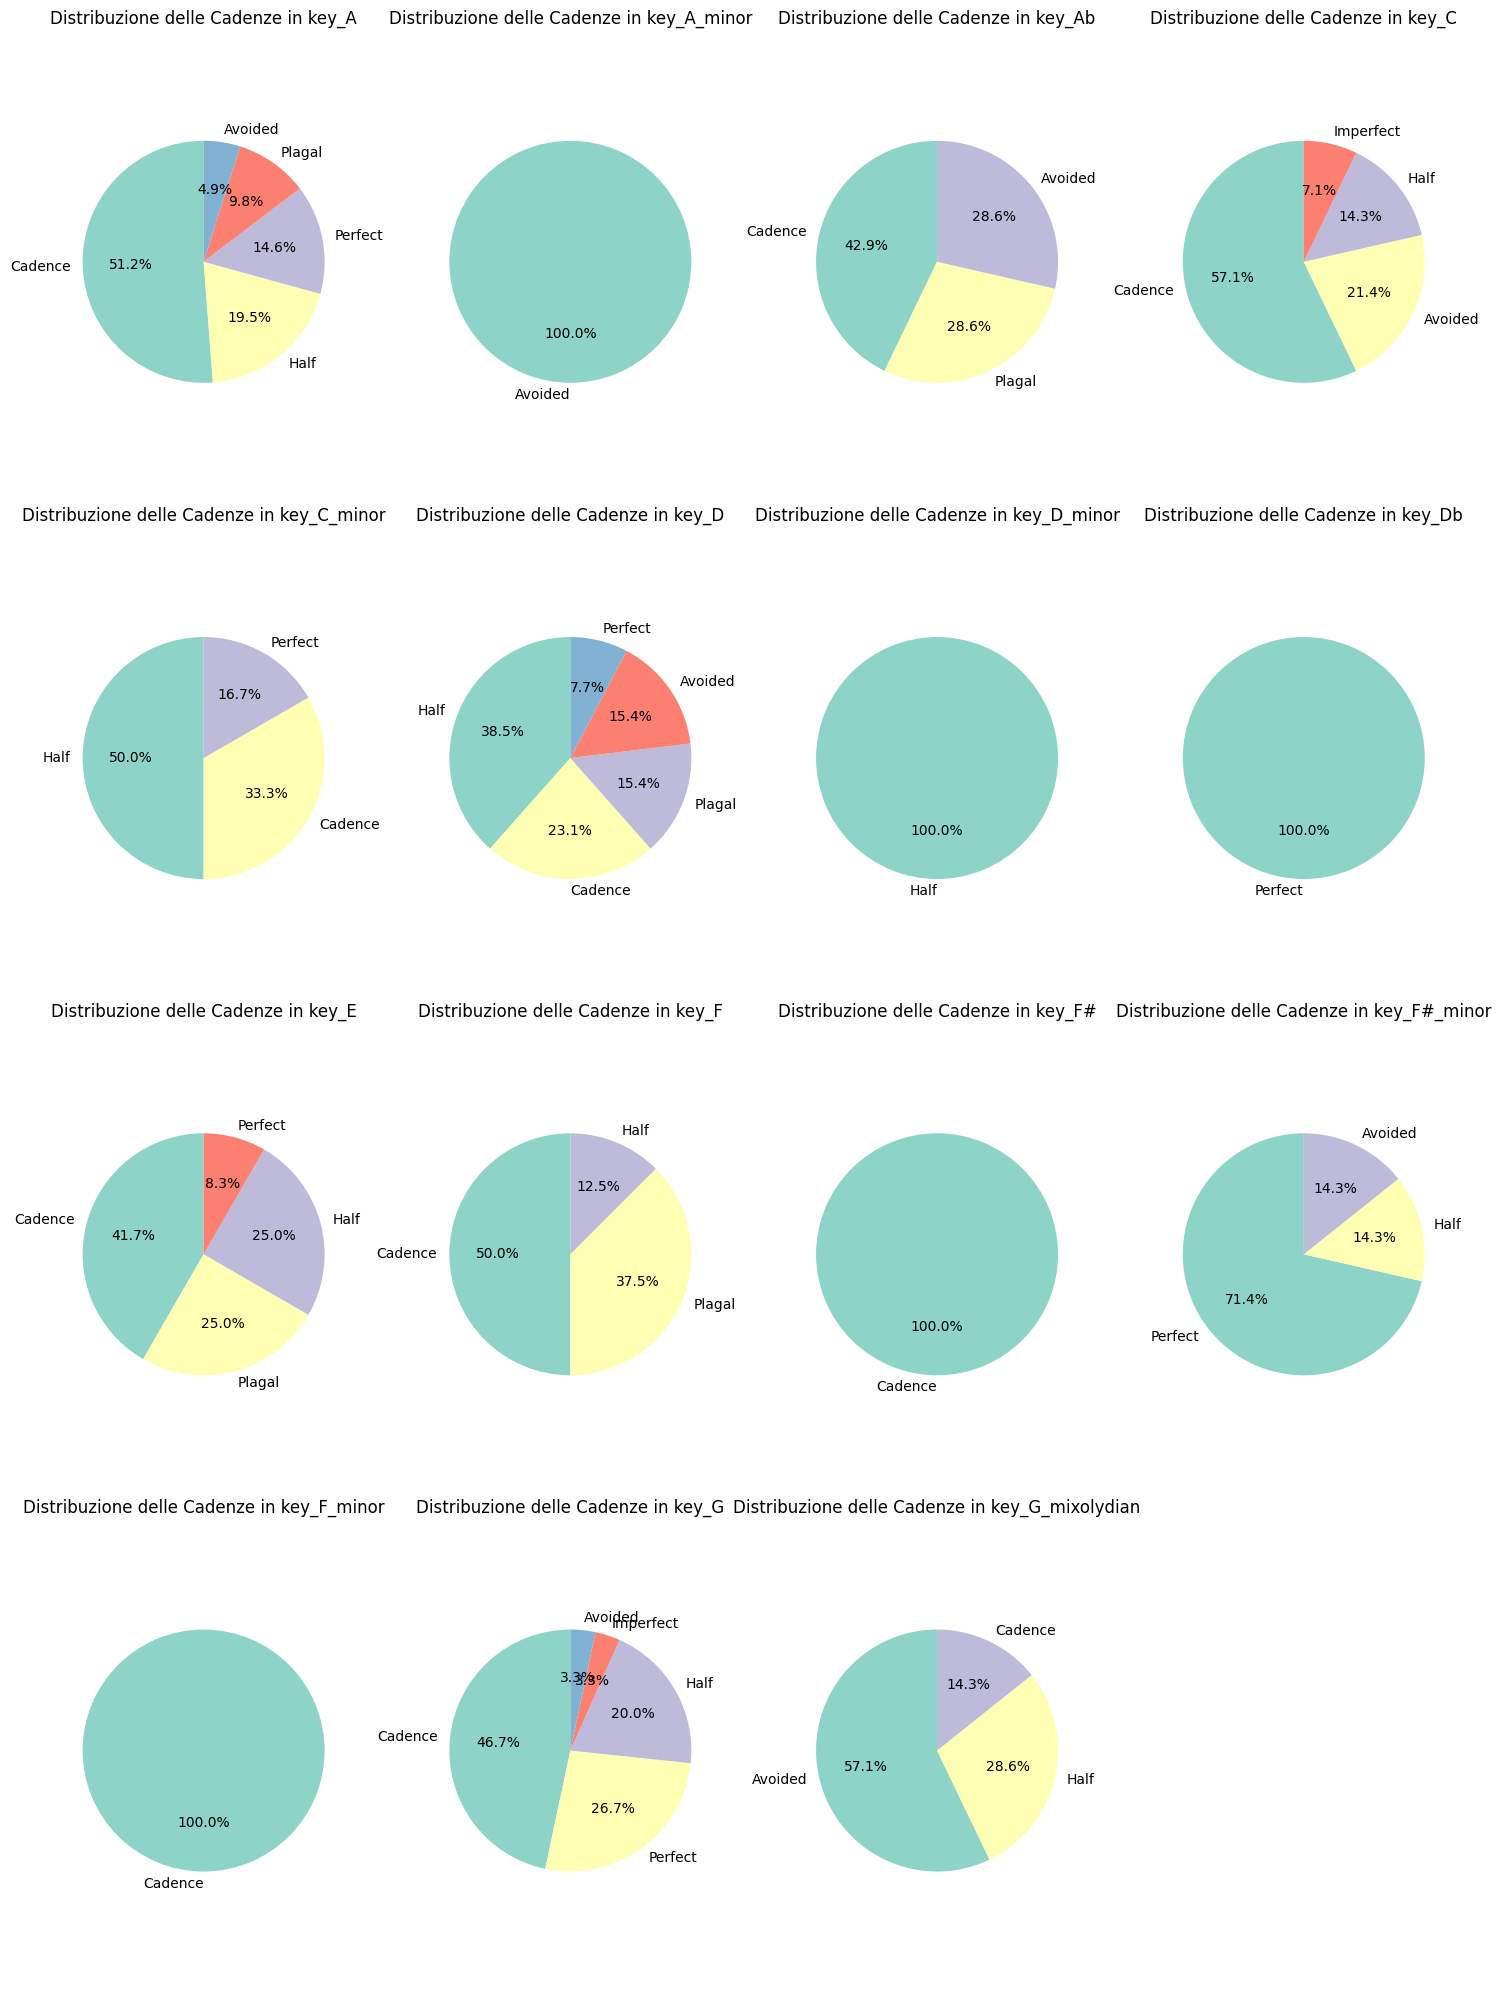

In [27]:
import matplotlib.pyplot as plt

def plot_cadence_distribution(cadence_data):
    # numero di colonne per i subplot
    num_columns = 4
    num_keys = len(cadence_data)
    num_rows = (num_keys // num_columns) + (num_keys % num_columns > 0)

    # subplot con dimensione adeguata
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

    axs = axs.ravel()  # Rende il vettore di assi "piatto" per iterarci facilmente

    # Iteriamo su  tonalità
    for i, (key, cadences) in enumerate(cadence_data.items()):
        # Calcolo il totale delle cadenze per la tonalità corrente
        total_cadences = sum(cadences.values())

        # Calcolo  percentuali
        percentages = {cadence_type: (count / total_cadences) * 100 for cadence_type, count in cadences.items()}


        labels = list(percentages.keys())
        sizes = list(percentages.values())
        colors = plt.cm.Set3(range(len(labels)))  # Utilizza una palette di colori chiara

        # grafico a torta nel subplot corrente
        axs[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

        # titolo
        axs[i].set_title(f'Distribuzione delle Cadenze in {key}')


        axs[i].axis('equal')

    # Rimuovi  assi vuoti se ci sono più subplot di quelli necessari
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])


    plt.tight_layout()
    plt.show()

plot_cadence_distribution(key_data)
